In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy
from dataset import Dataset

# Constants

In [168]:
DATASET_PATH = 'dataset/bag/'
NUM_BIN = 8

In [169]:
data = Dataset(DATASET_PATH)

# Kernel

In [170]:
BAND = 255 /NUM_BIN
def to_b_num(img):
    b = (img //BAND).astype(int)
    return numpy.minimum(b, 7)

In [171]:
def create_kernel(r, c):
    """
    create kernel with epancechnikov profile
    
    @param r, c: size
    """
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    C, R = numpy.meshgrid(cc, rr)
    X2 = C**2 + R**2
    
    kernel = numpy.maximum(1-X2, 0)
    return kernel / numpy.sum(kernel)

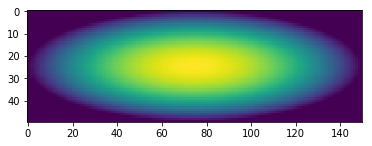

In [173]:
plt.imshow(create_kernel(50, 150))

# Target model

In [175]:
def create_target_model(target_img):
    B = to_b_num(target_img)
    
    kernel = create_kernel(*target_img.shape[:2])
    
    M = numpy.empty((NUM_BIN, 3))
    for b in range(NUM_BIN):
        for ch in range(3):
            M[b, ch] = numpy.sum(kernel[B[:,:,ch]==b])
            
    return M

In [176]:
create_target_model(data.target(0))

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.00499092,  0.00396631,  0.00072165],
       [ 0.10339642,  0.09344824,  0.08623304],
       [ 0.14151272,  0.16760138,  0.18993672],
       [ 0.08680921,  0.1887085 ,  0.32822262],
       [ 0.66329073,  0.54627557,  0.39488597]])

# Target Candidate

In [182]:
def create_target_candidate(img, center, diameter):
    """
    @param orig_img  the entire img
    @param num_bin   the num of hist bins
    @param center    center (x, y)
    @param diameter  mask diameter, aka normalized factor
    """
    R, C = img.shape[:2]
    c, r = center.astype(int)
    
    h = int(min(diameter/2, R-r, C-c)/2)
    h_2 = int(h/2)
    
    target_img = img[r-h_2:r+h_2, c-h_2:c+h_2]
    return create_target_model(target_img)

In [184]:
create_target_candidate(data.imgs[1], numpy.array([365, 194]), 132)

AttributeError: 'tuple' object has no attribute 'astype'

In [164]:
def calc_weight(img, target_model, target_candidate, center, diameter):
    diameter = int(diameter)

    cnr_c, cnr_r = center.astype(int) - (diameter >> 1)
    target_img = to_b_num(img[cnr_r:cnr_r+diameter, cnr_c:cnr_c+diameter])
    
    C = numpy.zeros((NUM_BIN, 3))
    idx = target_candidate > 0
    C[idx] = numpy.sqrt(target_model[idx] / target_candidate[idx])

    weight = numpy.empty((diameter, diameter))
    for i in range(diameter):
        for j in range(diameter):
            weight[i, j] = numpy.prod(C[target_img[i, j]])
    
    plt.imshow(weight)
    plt.colorbar()
    return weight

# Target Candidate

array([[  3.42477352e-01,   3.42477352e-01,   3.42477352e-01, ...,
          1.07529678e+03,   1.07529678e+03,   1.56654675e+01],
       [  3.42477352e-01,   3.42477352e-01,   3.42477352e-01, ...,
          1.07529678e+03,   1.07529678e+03,   1.07529678e+03],
       [  3.42477352e-01,   3.42477352e-01,   3.42477352e-01, ...,
          7.38096819e+04,   1.07529678e+03,   1.07529678e+03],
       ..., 
       [  7.38096819e+04,   0.00000000e+00,   0.00000000e+00, ...,
          7.38096819e+04,   7.38096819e+04,   7.38096819e+04],
       [  7.38096819e+04,   0.00000000e+00,   0.00000000e+00, ...,
          7.38096819e+04,   7.38096819e+04,   7.38096819e+04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          7.38096819e+04,   7.38096819e+04,   7.38096819e+04]])

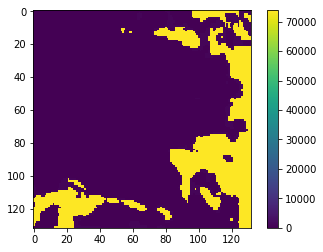

In [165]:
W = calc_weight(data.imgs[1], q, p, y0, h)
W

In [166]:
def meanshift(weight):
    # create G(X), derivation of kernel k(x)
    r, c = weight.shape
    
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    
    C, R = numpy.meshgrid(cc, rr)
    G = (C**2 + R**2) < 1
    
    # 
    density = weight *G
    plt.imshow(density)

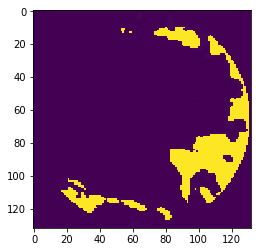

In [167]:
meanshift(W)

# Bhattacharyya Coefficient Maximization

Given the target model ${\{\hat{q_u}\}}_{u=1\dots m}$ and its location $\hat{y_0}$ in the previous frame

In [128]:
q = create_target_model(data.target(0))
q

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.00499092,  0.00396631,  0.00072165],
       [ 0.10339642,  0.09344824,  0.08623304],
       [ 0.14151272,  0.16760138,  0.18993672],
       [ 0.08680921,  0.1887085 ,  0.32822262],
       [ 0.66329073,  0.54627557,  0.39488597]])

In [129]:
y0 = numpy.average(data.gtruth[0], 0)
y0

array([ 365.21 ,  194.595])

initialize the location of the target in the current frame with $\hat{y_0}$, compute 
$$
{\{ \hat{p}_u {( \hat{y}_0 )} \}}_{u=1 \dots m}
$$
and evaluate
$$
\rho{[ \hat{p}{( \hat{y}_0 )}, \hat{q} ]}
=
\sum_{u=1}^{m}{\sqrt{
\hat{p}_u( \hat{y}_0 ) \hat{q}_u
}}
$$

In [130]:
h = numpy.min(numpy.diff(data.gtruth[0], axis=0))
h

132.46999999999997

In [131]:
p = create_target_candidate(data.imgs[1], y0, h)
p

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.0162712 ,  0.00518377,  0.00561404],
       [ 0.19463493,  0.2365752 ,  0.26197093],
       [ 0.11124786,  0.09482273,  0.08241354],
       [ 0.67784601,  0.6634183 ,  0.65000148]])

In [132]:
rho = numpy.sum(p * q, 0)
rho

array([ 0.48849202,  0.42043781,  0.33396847])